In [1]:
include("F_calculations.jl");
using BenchmarkTools

In [2]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

# Mass method
DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]

# νe method
function DSNB(E, z0, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB(E, z0, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB(E, z0, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB(E, z0, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end


# Separating the progenitors: 1pc ≡ one progenitor contribution

function DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)
    c0 = 3e8 # m s^(-1)
    # Adding in this integrated mass function so we can multiply by bh fractions at the end
    return 0.00208 * ηAD(125, 8) * (c0*normchoice*SFR(z)/Hubble(z)) * Fmass(E*(1+z)/(1+z0), i, sm, ordering, nubar)
end

DSNB_1pc(E, z0, i, nubar, ordering, sm, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice), z0, 5, rtol=1e-2)[1]

function DSNB_1pc(E, z0, nubar, ordering, sm, normchoice)
    ν1 = DSNB_1pc(E, z0, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_1pc(E, z0, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_1pc(E, z0, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [4]:
# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
lefftrue = extrapolate(leff_ne, 0.0)

# Approximating with a 14 degree polynomial

# Procedure for fitting the polynomial
#=
xsvec = range(0, 5, 100)
leffsvec = 70*leff.(xsvec)

p = Polynomials.fit(xsvec, leffsvec, 14)
=#

function leff(x) 
    if x == 0.0
        return 0.0
    else
        (3.844126829887412e-6 + 0.9994711237154343*x - 1.2171757160998375*x^2 + 1.2011732904692138*x^3 - 1.0258795580085436*x^4 + 0.7535135022231549*x^5 - 0.4576091931617817*x^6 + 0.2207326320476638*x^7 - 0.0820545498767346*x^8 + 0.022953521018636694*x^9 - 0.004712524469463747*x^(10) + 0.0006858791896371295*x^(11) - 6.682066367256103e-5*x^(12) + 3.9015397017829775e-6*x^(13) - 1.0310563080271216e-7*x^(14))/70
    end
end

# Decay function 
function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end;

In [5]:
# This function returns the redshift point where the decay function has attenuated by 
# roughly two orders of magnitude, and if we break the integral bounds at this point the integral might run faster
# with QuadGK.jl
function zcutoff(E, α, z0)
    innerpart = 0.007+(E/(4.68e28*α))*log(0.01*exp(-4.68e28*α*leff(z0)/E))
    if innerpart > 0.0
        return -0.555*(log(350*(innerpart))-0.9)
    else
        return 0.0
    end
end;

In [6]:
# Invisible decay implementation

# Mass method
function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

# νe method
function DSNB_idecay(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end

# Single progenitor versions
function DSNB_idecay_1pc(E, z0, α, i, nubar, ordering, sm, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

function DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, sm, normchoice)
    ν1 = DSNB_idecay_1pc(E, z0, α1, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, z0, α2, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, z0, α3, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [7]:
# Energy spectrum function for SH case
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end;

In [30]:
# 3ν NO SH treatment

function branch_3ν_NO(casechoice, j, i)
    if casechoice == "B"
        if j == 3 && i == 2
            return 0.5
        elseif j == 2 && i == 1
            return 0.5
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 3 && i == 1
            return 0.5
        elseif j == 2 && i == 1
            return 0.5
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if j == 3
            return 0.25
        elseif j == 2
            return 0.5
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function q3icontrib_NO(E, z0, z, α3, threebar, i, ibar, casechoice, bh_frac, normchoice)
    if threebar == ibar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, α3, 3, threebar, "NO", bh_frac, normchoice) * (α3 * branch_3ν_NO(casechoice, 3, i)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

function DSNB_vdecay_2_NO(E, z0, α3, α2, twobar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, z0, z, 2, twobar, "NO", bh_frac, normchoice) +
                          q3icontrib_NO(E, z0, z, α3, true, 2, twobar, casechoice, bh_frac, normchoice) + q3icontrib_NO(E, z0, z, α3, false, 2, twobar, casechoice, bh_frac, normchoice))*decay(E, α2, z0, z)
    zcut = zcutoff(E, α2, z0)
    if zcut > z0 && zcut < 5 && decay(E, α2, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q21contrib_NO(E, z0, z, α3, α2, twobar, onebar, casechoice, bh_frac, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO(Eprime, z, α3, α2, twobar, casechoice, bh_frac, normchoice) * (α2 * branch_3ν_NO(casechoice, 2, 1)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

# z0 is always 0 here because we're only concerned with the flux at Earth
function DSNB_vdecay_1_NO(E, α3, α2, onebar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 1, onebar, "NO", casechoice, bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, true, onebar, casechoice, bh_frac, normchoice)
                    + q21contrib_NO(E, 0, z, α3, α2, false, onebar, casechoice, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, true, 1, onebar, casechoice, bh_frac, normchoice)
                    + q3icontrib_NO(E, 0, z, α3, false, 1, onebar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_NO(E, α3, α2, nubar, casechoice, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, 0, α3, 3, nubar, "NO", bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_NO(E, 0, α3, α2, nubar, casechoice, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_NO(E, α3, α2, nubar, casechoice, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

# Single progenitor versions

function q3icontrib_NO_1pc(E, z0, z, α3, threebar, i, ibar, casechoice, sm, normchoice)
    if threebar == ibar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Eprime, z, α3, 3, threebar, "NO", sm, normchoice) * (α3 * branch_3ν_NO(casechoice, 3, i)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]

end

function DSNB_vdecay_2_NO_1pc(E, z0, α3, α2, twobar, casechoice, sm, normchoice)
    integrand(z) = (DSNB_integrand_1pc(E, z0, z, 2, twobar, "NO", sm, normchoice) +
                          q3icontrib_NO_1pc(E, z0, z, α3, true, 2, twobar, casechoice, sm, normchoice) + q3icontrib_NO_1pc(E, z0, z, α3, false, 2, twobar, casechoice, sm, normchoice))*decay(E, α2, z0, z)
    zcut = zcutoff(E, α2, z0)
    if zcut > z0 && zcut < 5 && decay(E, α2, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q21contrib_NO_1pc(E, z0, z, α3, α2, twobar, onebar, casechoice, sm, normchoice)
    if twobar == onebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NO_1pc(Eprime, z, α3, α2, twobar, casechoice, sm, normchoice) * (α2 * branch_3ν_NO(casechoice, 2, 1)/Eprime) * ψSH(Eprime, Ers, hc)
    
    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_1_NO_1pc(E, α3, α2, onebar, casechoice, sm, normchoice)
    integrand(z) = (DSNB_integrand_1pc(E, 0, z, 1, onebar, "NO", casechoice, sm, normchoice)
                    + q21contrib_NO_1pc(E, 0, z, α3, α2, true, onebar, casechoice, sm, normchoice)
                    + q21contrib_NO_1pc(E, 0, z, α3, α2, false, onebar, casechoice, sm, normchoice)
                    + q3icontrib_NO_1pc(E, 0, z, α3, true, 1, onebar, casechoice, sm, normchoice)
                    + q3icontrib_NO_1pc(E, 0, z, α3, false, 1, onebar, casechoice, sm, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_NO_1pc(E, α3, α2, nubar, casechoice, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, 0, α3, 3, nubar, "NO", sm, normchoice)
    ν2 = DSNB_vdecay_2_NO_1pc(E, 0, α3, α2, nubar, casechoice, sm, normchoice)
    ν1 = DSNB_vdecay_1_NO_1pc(E, α3, α2, nubar, casechoice, sm, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end; 

In [59]:
# 3ν NO QD treatment

function branch_3ν_NOQD(casechoice, j, i)
    if casechoice == "B"
        if j == 3 && i == 2
            return 1.0
        elseif j == 2 && i == 1
            return 1.0
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 3 && i == 1
            return 1.0
        elseif j == 2 && i == 1
            return 1.0
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if j == 3
            return 0.5
        elseif j == 2
            return 1.0
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function q3icontrib_NOQD(E, z0, z, α3, i, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z))*DSNB_idecay(Ers, z, α3, 3, nubar, "NO", bh_frac, normchoice) * (α3 * branch_3ν_NOQD(casechoice, 3, i)/Ers)

end

function DSNB_vdecay_2_NOQD(E, z0, α3, α2, nubar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, z0, z, 2, nubar, "NO", bh_frac, normchoice) +
                          q3icontrib_NOQD(E, z0, z, α3, 2, nubar, casechoice, bh_frac, normchoice))*decay(E, α2, z0, z)
    zcut = zcutoff(E, α2, z0)
    if zcut > z0 && zcut < 5 && decay(E, α2, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q21contrib_NOQD(E, z0, z, α3, α2, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NOQD(Ers, z, α3, α2, nubar, casechoice, bh_frac, normchoice) * (α2 * branch_3ν_NOQD(casechoice, 2, 1)/Ers)
    
end

function DSNB_vdecay_1_NOQD(E, α3, α2, nubar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 1, nubar, "NO", bh_frac, normchoice)
                    + q21contrib_NOQD(E, 0, z, α3, α2, nubar, casechoice, bh_frac, normchoice)
                    + q3icontrib_NOQD(E, 0, z, α3, 1, nubar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_NOQD(E, α3, α2, nubar, casechoice, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, 0, α3, 3, nubar, "NO", bh_frac, normchoice)
    ν2 = DSNB_vdecay_2_NOQD(E, 0, α3, α2, nubar, casechoice, bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_NOQD(E, α3, α2, nubar, casechoice, bh_frac, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end

# Single progenitor versions

function q3icontrib_NOQD_1pc(E, z0, z, α3, i, nubar, casechoice, sm, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Ers, z, α3, 3, nubar, "NO", sm, normchoice) * (α3 * branch_3ν_NOQD(casechoice, 3, i)/Ers)

end

function DSNB_vdecay_2_NOQD_1pc(E, z0, α3, α2, nubar, casechoice, sm, normchoice)
    integrand(z) = (DSNB_integrand_1pc(E, z0, z, 2, nubar, "NO", sm, normchoice) +
                          q3icontrib_NOQD_1pc(E, z0, z, α3, 2, nubar, casechoice, sm, normchoice))*decay(E, α2, z0, z)
    zcut = zcutoff(E, α2, z0)
    if zcut > z0 && zcut < 5 && decay(E, α2, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q21contrib_NOQD_1pc(E, z0, z, α3, α2, nubar, casechoice, sm, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z))*DSNB_vdecay_2_NOQD_1pc(Ers, z, α3, α2, nubar, casechoice, sm, normchoice) * (α2 * branch_3ν_NOQD(casechoice, 2, 1)/Ers)
    
end

function DSNB_vdecay_1_NOQD_1pc(E, α3, α2, nubar, casechoice, sm, normchoice)
    integrand(z) = (DSNB_integrand_1pc(E, 0, z, 1, nubar, "NO", sm, normchoice)
                    + q21contrib_NOQD_1pc(E, 0, z, α3, α2, nubar, casechoice, sm, normchoice)
                    + q3icontrib_NOQD_1pc(E, 0, z, α3, 1, nubar, casechoice, sm, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_NOQD_1pc(E, α3, α2, nubar, casechoice, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, 0, α3, 3, nubar, "NO", sm, normchoice)
    ν2 = DSNB_vdecay_2_NOQD_1pc(E, 0, α3, α2, nubar, casechoice, sm, normchoice)
    ν1 = DSNB_vdecay_1_NOQD_1pc(E, α3, α2, nubar, casechoice, sm, normchoice)
    return Usqred("NO")[1, 1]*ν1 + Usqred("NO")[1, 2]*ν2 + Usqred("NO")[1, 3]*ν3
end;

In [56]:
es_dsnb = range(0.5, 40, 100)

dsnb_nodecay_test = DSNB.(es_dsnb, 0, true, "NO", "21", SNRnorm)
dsnb_vdecay_NOQD_B = DSNB_vdecay_3ν_νe_NOQD.(es_dsnb, 1e-23, 1e-23, true, "B", "21", SNRnorm)
dsnb_vdecay_NOQD_C = DSNB_vdecay_3ν_νe_NOQD.(es_dsnb, 1e-23, 1e-23, true, "C", "21", SNRnorm)
dsnb_vdecay_NOQD_D = DSNB_vdecay_3ν_νe_NOQD.(es_dsnb, 1e-23, 1e-23, true, "democratic", "21", SNRnorm)
dsnb_vdecay_NOQD_B_part = DSNB_vdecay_3ν_νe_NOQD.(es_dsnb, 1e-25, 1e-25, true, "B", "21", SNRnorm)
dsnb_vdecay_NOQD_C_part = DSNB_vdecay_3ν_νe_NOQD.(es_dsnb, 1e-25, 1e-25, true, "C", "21", SNRnorm);

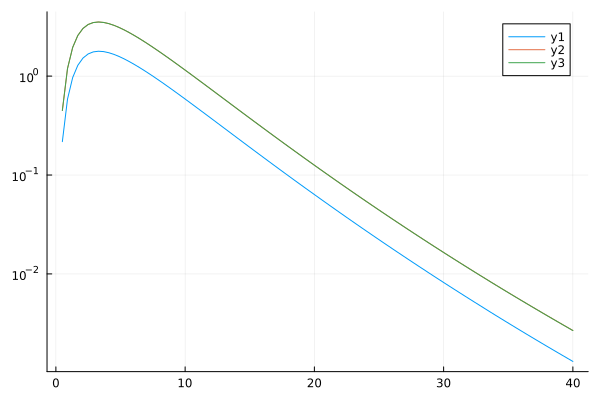

In [57]:
plot(
    es_dsnb,
    [dsnb_nodecay_test dsnb_vdecay_NOQD_D dsnb_vdecay_NOQD_B],
    yscale=:log10
)

In [23]:
compile1 = DSNB_integrand(1, 0, 0.1, 1, true, "IO", "21", SNRnorm)
compile2 = DSNB(1, 0, 1, true, "IO", "21", SNRnorm)
compile3 = DSNB_1pc(1, 0, 1, true, "IO", "small", SNRnorm)
compile4 = DSNB_idecay(10, 0, 10^(-24), 1, true, "IO", "21", SNRnorm)
compile5 = DSNB_idecay(10, 0, 10^(-24), 10^(-24), 10^(-24), true, "IO", "21", SNRnorm)
compile6 = DSNB_idecay_1pc(10, 0, 10^(-24), 1, true, "IO", "small", SNRnorm)
compile7 = DSNB_idecay_1pc(10, 0, 10^(-24), 10^(-24), 10^(-24), true, "IO", "small", SNRnorm);

In [27]:
@time q3icontrib_NO(1, 0, 0, 1e-24, true, 2, true, "B", "21", SNRnorm)

  0.001456 seconds (9.05 k allocations: 147.609 KiB)


0.05160639433426947

In [29]:
@time DSNB_vdecay_2_NO(1, 0, 1e-24, 1e-24, true, "B", "21", SNRnorm)

  0.063119 seconds (481.84 k allocations: 7.671 MiB)


0.000612137797657459

In [20]:
@time q21contrib_NO(1, 0, 0, 1e-24, 1e-24, true, true, "21", SNRnorm)

  4.738099 seconds (25.72 M allocations: 405.765 MiB, 8.89% gc time)


0.21117679503224596

In [21]:
@time DSNB_vdecay_1_NO(1, 1e-24, 1e-24, true, "21", SNRnorm)

1142.154018 seconds (2.25 G allocations: 64.950 GiB, 7.57% gc time, 77.42% compilation time)


8.44148731401271